# Predicting the Price of Hamilton Tickets

#### Importing

In [1]:
import pandas as pd
pd.set_option('display.max_rows', None)
import matplotlib.pyplot as plt
%matplotlib inline
from pandas import Series
import warnings
warnings.filterwarnings('ignore')
import numpy as np
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
from math import sqrt
from statsmodels.tools.eval_measures import rmse, aic
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
import itertools
from matplotlib.pylab import rcParams

#### Reading in the csv file

In [2]:
df = pd.read_csv('gross.csv')
df.head()

,week_ending,week_number,weekly_gross_overall,show,theatre,weekly_gross,potential_gross,avg_ticket_price,top_ticket_price,seats_sold,seats_in_theatre,pct_capacity,performances,previews
0,1985-06-09,1,3915937.0,42nd Street,St. James Theatre,282368.0,NaN,30.42,NaN,9281,1655,0.7010,8,0
1,1985-06-09,1,3915937.0,A Chorus Line,Sam S. Shubert Theatre,222584.0,NaN,27.25,NaN,8167,1472,0.6935,8,0
2,1985-06-09,1,3915937.0,Aren't We All?,Brooks Atkinson Theatre,249272.0,NaN,33.75,NaN,7386,1088,0.8486,8,0
3,1985-06-09,1,3915937.0,Arms and the Man,Circle in the Square Theatre,95688.0,NaN,20.87,NaN,4586,682,0.8405,8,0
4,1985-06-09,1,3915937.0,As Is,Lyceum Theatre,61059.0,NaN,20.78,NaN,2938,684,0.5369,8,0


#### Selecting the rows and columns that we want

In [3]:
# Only get the rows and columns that we want

# Step 1: Only get the show Hamilton
df = df[(df['show'] == 'Hamilton')]

# Step 2: Drop all columns except 'week_ending' and 'weekly_gross'
df.drop(['week_number','weekly_gross_overall', 'show', 'theatre', 'potential_gross',
              'avg_ticket_price', 'top_ticket_price', 'seats_sold', 'seats_in_theatre', 
              'pct_capacity', 'performances', 'previews'], axis=1, inplace = True) 

# Step 3: change name from 'week_ending' to 'date' AND 'weekly_gross' to just 'gross'
df.rename(columns = {"week_ending": "date"}, inplace = True) 
df.rename(columns = {"weekly_gross": "gross"}, inplace = True)

# Step 4: change date column to type 'datetime64[ns]'
df['date'] = df['date'].astype('datetime64[ns]')

# set the df equal to month and create a month column so we can create a season column later on
df_month = df

# Step 5: make date the index
df.set_index('date', inplace=True)

#Step 6: Set it equal to 'df_week'
df_week = df

#Step 7: Look at the final table
df_month.head()

,gross
date,
2015-07-19,1288436.0
2015-07-26,1302511.0
2015-08-02,1490816.0
2015-08-09,1255163.0
2015-08-16,1459314.0


                 gross
date                  
2015-07-01  1295473.50
2015-08-01  1442194.80
2015-09-01  1592876.75
2015-10-01  1531843.25
2015-11-01  1649660.40


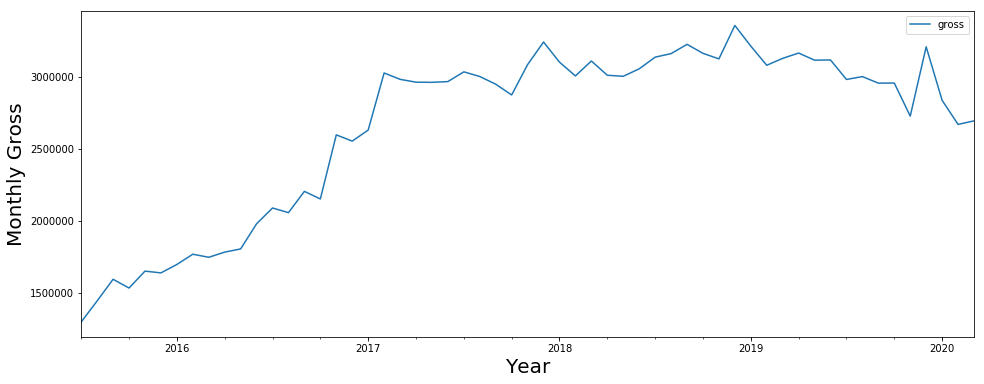

In [4]:
# Downsampling to a month
df_month = df.resample('MS').mean()
print(df_month.head())

# line plot for a month at a time
df_month.plot(figsize = (16,6));
plt.xlabel('Year', fontsize=20)
plt.ylabel('Monthly Gross', fontsize=20)
plt.show()

### EDA

### Check for Stationarity

In [5]:
ts = df_month

In [6]:
# Create a function to check for the stationarity of a given time series using rolling stats and DF test

def stationarity_check(TS):
    
    # Import adfuller
    from statsmodels.tsa.stattools import adfuller
    
    # Calculate rolling statistics
    roll_mean = TS.rolling(window=8, center=False).mean()
    roll_std = TS.rolling(window=8, center=False).std()
    
    # Perform the Dickey Fuller Test
    dftest = adfuller(TS['gross'])

    
    # Print Dickey-Fuller test results
    print('Results of Dickey-Fuller Test: \n')

    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', 
                                             '#Lags Used', 'Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)
    
    return None

In [7]:
stationarity_check(ts)

Results of Dickey-Fuller Test: 

Test Statistic                 -2.481191
p-value                         0.120118
#Lags Used                      2.000000
Number of Observations Used    54.000000
Critical Value (1%)            -3.557709
Critical Value (5%)            -2.916770
Critical Value (10%)           -2.596222
dtype: float64


The p-value of .12 is higher than our alpha of .05, therefore we fail to reject the null hypothesis.

In [8]:
# Detrend the data by taking the square root
ts_sqrt = np.sqrt(ts)
stationarity_check(ts_sqrt)

Results of Dickey-Fuller Test: 

Test Statistic                 -2.888194
p-value                         0.046738
#Lags Used                      1.000000
Number of Observations Used    55.000000
Critical Value (1%)            -3.555273
Critical Value (5%)            -2.915731
Critical Value (10%)           -2.595670
dtype: float64


The p-value of .0467 is lower than our alpha of .05, therefore we reject the null hypothesis and conclude that our date is stationary.

In [9]:
X = ts_sqrt['gross']

#### Check the ACF and PACF

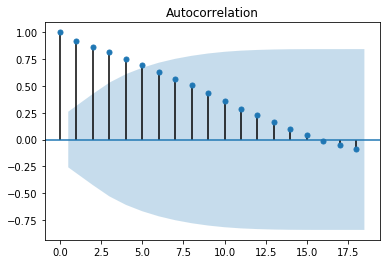

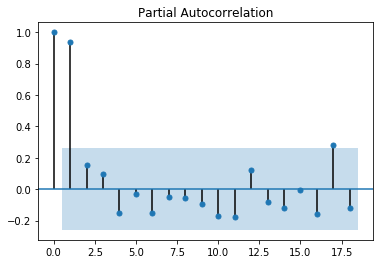

In [10]:
alpha=.05
plot_acf(X, alpha=alpha);
plot_pacf(X, alpha=alpha);

Results: 
1. ACF - Strongly positively correlated lags we will use for the MA model
2. PACF - only the first lag is strongly correlated

# Modeling

#### Baseline Models - ARIMA

When a data set has no seasonality, there is strong dependence among values, and it is non-stationary then we use an ARIMA model. I detrended the data by taking the square root, performed a DIckey-Fuller Test to check the stationarity, and then used an ARIMA model as my baseline to see how it predicts. 

In [11]:
# To show the scores of all the models throughout the notebook
scores = {}

In [12]:
# Full Arima model which prints out the predicted and actual scores of 2019
def build_arima_full(p,d,q):
    X = ts_sqrt['gross']
    train, test = X['2015-07-01':'2018-12-01'], X['2019-01-01':'2019-12-01']
    history = [x for x in train]
    predictions = list()
    for t in range(len(test)):
        model = ARIMA(history, order=(p,d,q))
        model_fit = model.fit(disp=0)
        output = model_fit.forecast()
        yhat = output[0]
        predictions.append(yhat)
        obs = test[t]
        history.append(obs)
        print('Month = %.0f-2019, predicted = $%.2f, expected = $%.2f' % (t+1, yhat**2, obs**2))
    rmse = sqrt(mean_squared_error(test**2, np.array(predictions)**2))
    print('Test RMSE: $%.2f' % rmse)
    scores['Baseline ARIMA', (p,d,q)] = rmse
    scores

In [13]:
# Just prints out the RMSE of the test set
def build_arima(p,d,q):
    X = ts_sqrt['gross']
    train, test = X['2015-07-01':'2018-12-01'], X['2019-01-01':'2019-12-01']
    history = [x for x in train]
    predictions = list()
    for t in range(len(test)):
        model = ARIMA(history, order=(p,d,q))
        model_fit = model.fit(disp=0)
        output = model_fit.forecast()
        yhat = output[0]
        predictions.append(yhat)
        obs = test[t]
        history.append(obs)
#       print('Month = %.0f-2019, predicted = $%.2f, expected = $%.2f' % (t+1, yhat, obs))
    rmse = sqrt(mean_squared_error(test**2, np.array(predictions)**2))
    print('pdq =',p,d,q)
    print('Test RMSE: $%.2f' % rmse)
    scores['Baseline ARIMA ', (p,d,q)] = rmse
    scores

In [14]:
# Building all the baseline models
build_arima(0,0,0)
build_arima(0,0,1)
build_arima(0,0,2)
build_arima(0,1,0)
build_arima(0,1,1)
build_arima(0,1,2)
print('- - - - - - - -')
build_arima(1,0,0)
build_arima(1,0,1)
build_arima(1,0,2)
build_arima(1,1,0)
build_arima(1,1,1)
print('- - - - - - - -')
build_arima(2,0,0)
build_arima(2,0,1)
build_arima(2,0,2)
build_arima(2,1,0)
build_arima(2,1,1)

pdq = 0 0 0
Test RMSE: $517814.16
pdq = 0 0 1
Test RMSE: $336855.87
pdq = 0 0 2
Test RMSE: $252381.64
pdq = 0 1 0
Test RMSE: $184765.90
pdq = 0 1 1
Test RMSE: $183121.22
pdq = 0 1 2
Test RMSE: $182465.96
- - - - - - - -
pdq = 1 0 0
Test RMSE: $170362.10
pdq = 1 0 1
Test RMSE: $168121.34
pdq = 1 0 2
Test RMSE: $167063.33
pdq = 1 1 0
Test RMSE: $182513.50
pdq = 1 1 1
Test RMSE: $183165.58
- - - - - - - -
pdq = 2 0 0
Test RMSE: $167808.39


/Users/yehudaschein/.local/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/yehudaschein/.local/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


pdq = 2 0 1
Test RMSE: $163825.73


/Users/yehudaschein/.local/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


pdq = 2 0 2
Test RMSE: $159765.09
pdq = 2 1 0
Test RMSE: $184693.80
pdq = 2 1 1
Test RMSE: $189559.11


In [36]:
build_arima(12,1,1)

/Users/yehudaschein/.local/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/yehudaschein/.local/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/yehudaschein/.local/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/yehudaschein/.local/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


pdq = 12 1 1
Test RMSE: $165593.75


/Users/yehudaschein/.local/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


In [15]:
# Showing a list of all the baseline models and their RMSE scores
s = pd.DataFrame.from_dict(scores, orient='index',columns = ['RMSE'])
s.index.name = 'Baseline models'
s.sort_values(by = 'RMSE')

,RMSE
Baseline models,
"(Baseline ARIMA , (2, 0, 2))",159765.090320
"(Baseline ARIMA , (2, 0, 1))",163825.732263
"(Baseline ARIMA , (1, 0, 2))",167063.326719
"(Baseline ARIMA , (2, 0, 0))",167808.389732
"(Baseline ARIMA , (1, 0, 1))",168121.336323
"(Baseline ARIMA , (1, 0, 0))",170362.103437
"(Baseline ARIMA , (0, 1, 2))",182465.960825
"(Baseline ARIMA , (1, 1, 0))",182513.500994
"(Baseline ARIMA , (0, 1, 1))",183121.223955


The baseline model with the parameters (2,0,2) performed the best with an RMSE of 159765

#### SARIMA Models - Parameter Selection

Because there are seasonal patterns in the date set from the spikes in December for holiday season, I decided to use a SARIMA model which takes seasonality into account. For this model I used the original monthly data set which was not detrended. Using the SARIMA model I performed a grid search to find the besyt hyper-parameters. 

In [16]:
# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 2)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
pdqs = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

In [17]:
# Run a grid with pdq and seasonal pdq parameters calculated above and get the best AIC value
ans = []
for comb in pdq:
    for combs in pdqs:
        try:
            mod = SARIMAX(df_month,
                                            order=comb,
                                            seasonal_order=combs,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            output = mod.fit()
            ans.append([comb, combs, output.aic])
            print('ARIMA {} x {}12 : AIC Calculated ={}'.format(comb, combs, output.aic))
        except:
            continue

ARIMA (0, 0, 0) x (0, 0, 0, 12)12 : AIC Calculated =1821.3630964057124
ARIMA (0, 0, 0) x (0, 0, 1, 12)12 : AIC Calculated =1409.4467113794053
ARIMA (0, 0, 0) x (0, 1, 0, 12)12 : AIC Calculated =1298.0956206910537
ARIMA (0, 0, 0) x (0, 1, 1, 12)12 : AIC Calculated =2932.491986077116
ARIMA (0, 0, 0) x (1, 0, 0, 12)12 : AIC Calculated =1321.8832745705633
ARIMA (0, 0, 0) x (1, 0, 1, 12)12 : AIC Calculated =1275.0421645462957
ARIMA (0, 0, 0) x (1, 1, 0, 12)12 : AIC Calculated =935.9236620670023
ARIMA (0, 0, 0) x (1, 1, 1, 12)12 : AIC Calculated =2900.5618325007467
ARIMA (0, 0, 1) x (0, 0, 0, 12)12 : AIC Calculated =1752.293039163315
ARIMA (0, 0, 1) x (0, 0, 1, 12)12 : AIC Calculated =1467.1502925956838
ARIMA (0, 0, 1) x (0, 1, 0, 12)12 : AIC Calculated =1241.0528787270923
ARIMA (0, 0, 1) x (0, 1, 1, 12)12 : AIC Calculated =2908.7559410094036
ARIMA (0, 0, 1) x (1, 0, 0, 12)12 : AIC Calculated =1425.3949256340998
ARIMA (0, 0, 1) x (1, 0, 1, 12)12 : AIC Calculated =1363.9538670393358
ARIMA (0,

In [18]:
# Find the parameters with minimal AIC value
ans_df = pd.DataFrame(ans, columns=['pdq', 'pdqs', 'aic'])
# ans_df['aic'] = pd.to_numeric(ans_df['aic'])
ans_df.loc[ans_df['aic'].idxmin()]

pdq         (1, 1, 0)
pdqs    (1, 1, 0, 12)
aic           833.186
Name: 54, dtype: object

The output of our code suggests that ARIMA(1, 1, 0)x(1, 1, 0, 12) yields the lowest AIC value of 833.186. We should therefore consider this to be optimal option out of all the models we have considered.

In [19]:
# Plug the optimal parameter values into a new SARIMAX model
ARIMA_MODEL = SARIMAX(df_month, 
                                        order=(1, 1, 0), 
                                        seasonal_order=(1, 1, 0, 12), 
                                        enforce_stationarity=False, 
                                        enforce_invertibility=False)

# Fit the model and print results
output = ARIMA_MODEL.fit()

print(output.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2727      0.215     -1.268      0.205      -0.694       0.149
ar.S.L12      -0.2285      0.135     -1.691      0.091      -0.493       0.036
sigma2      2.345e+10   3.55e-12   6.61e+21      0.000    2.35e+10    2.35e+10


In [20]:
X = df_month['gross']
train, test = X['2015-07-01':'2018-12-01'], X['2019-01-01':'2019-12-01']
history = [x for x in train]
predictions = list()
for t in range(len(test)):
    model = SARIMAX(history, order=(1,1,0),  seasonal_order=(1, 1, 0, 12))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)
    print('Month = %.0f-2019, predicted = $%.2f, expected = $%.2f' % (t+1, yhat, obs))
rmse = sqrt(mean_squared_error(test, predictions))
print('Test RMSE: $%.2f' % rmse)
scores['SARIMA FROM GS (1,1,0) (1,1,0,12)'] = rmse

Month = 1-2019, predicted = $3242174.94, expected = $3216767.25
Month = 2-2019, predicted = $3154521.64, expected = $3083388.25
Month = 3-2019, predicted = $3175148.37, expected = $3131449.50
Month = 4-2019, predicted = $3033681.68, expected = $3168584.75
Month = 5-2019, predicted = $3169863.38, expected = $3118766.25
Month = 6-2019, predicted = $3165342.14, expected = $3120375.40
Month = 7-2019, predicted = $3197752.68, expected = $2984510.75
Month = 8-2019, predicted = $2991587.97, expected = $3004554.00
Month = 9-2019, predicted = $3061219.26, expected = $2958985.20
Month = 10-2019, predicted = $2889225.39, expected = $2959574.75
Month = 11-2019, predicted = $2942202.03, expected = $2729291.50
Month = 12-2019, predicted = $2947516.71, expected = $3212040.40
Test RMSE: $131273.13


In [21]:
# Updating the list of all the models and their RMSE scores
s = pd.DataFrame.from_dict(scores, orient='index',columns = ['RMSE'])
s.index.name = 'Models'
s.sort_values(by = 'RMSE')

,RMSE
Models,
"SARIMA FROM GS (1,1,0) (1,1,0,12)",131273.129735
"(Baseline ARIMA , (2, 0, 2))",159765.090320
"(Baseline ARIMA , (2, 0, 1))",163825.732263
"(Baseline ARIMA , (1, 0, 2))",167063.326719
"(Baseline ARIMA , (2, 0, 0))",167808.389732
"(Baseline ARIMA , (1, 0, 1))",168121.336323
"(Baseline ARIMA , (1, 0, 0))",170362.103437
"(Baseline ARIMA , (0, 1, 2))",182465.960825
"(Baseline ARIMA , (1, 1, 0))",182513.500994


We can see that the SARIMA grid search model performed the best of all the models with an RMSE of 131273

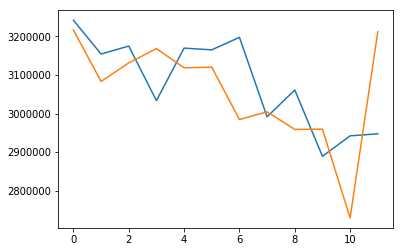

In [22]:
plt.plot(range(12), predictions)
plt.plot(range(12), test)

This plot shows my predicted scores in blue and the actual scores in orange

### Adding exogenous variables

I created a few exogenous variables to try and improve my model. In the end, these exognenous variables did not beat my grid search SARIMA RMSE, but they still did perform well. In this cell I will go through the four exogenous variables which I added.
1. Month - I simply created the month of the year as an exog variable to see if that had an effect on the gross of the show
2. I made another variable called season which contains the season of the year
3. I made a yes or no column which contains yes if there is a holiday in that month
4. I created another yes or no column which says yes if Lin-Manuel Miranda, the star and writer of the show, is in the show. He was only in the show for the first 13 months

In [23]:
# Create a new df for the exog variables 
df_month_exog = df_month.copy()

In [24]:
df_month_exog.reset_index(inplace=True)
# add month as an exog variable
df_month_exog['month'] = pd.DatetimeIndex(df_month_exog['date']).month
df_month_exog.set_index('date', inplace=True)
# add season as an exog variable 
df_month_exog['season'] = ' '
df_month_exog['season'] = np.where((df_month_exog['month'] == 1) | 
                        (df_month_exog['month'] == 2) | 
                        (df_month_exog['month'] == 3), 
                        'Winter', df_month_exog['season'])
df_month_exog['season'] = np.where((df_month_exog['month'] == 4) | 
                        (df_month_exog['month'] == 5) | 
                        (df_month_exog['month'] == 6), 
                        'Spring', df_month_exog['season'])
df_month_exog['season'] = np.where((df_month_exog['month'] == 7) | 
                        (df_month_exog['month'] == 8) | 
                        (df_month_exog['month'] == 9), 
                        'Summer', df_month_exog['season'])
df_month_exog['season'] = np.where((df_month_exog['month'] == 10) | 
                        (df_month_exog['month'] == 11) | 
                        (df_month_exog['month'] == 12), 
                        'Fall', df_month_exog['season'])

In [25]:
## add whether or not there is a holiday in the month
df_month_exog['holiday'] = ' '
df_month_exog['holiday'] = np.where((df_month_exog['month'] == 1) | # New Years
                                    (df_month_exog['month'] == 2) | # Presidents Week
                                    (df_month_exog['month'] == 5) | # Memorial Day
                                    (df_month_exog['month'] == 7) | # Independence Day
                                    (df_month_exog['month'] == 9) | # Labor Day
                                    (df_month_exog['month'] == 10) | # Halloween / Columbus Day
                                    (df_month_exog['month'] == 11) | # Thanksgiving
                                    (df_month_exog['month'] == 12), # Christmas
                                    'Yes', df_month_exog['holiday'])

In [26]:
# add whether or not Lin-Manuel Miranda is in the show (pre Aug 2016)
df_month_exog.reset_index(inplace=True)
df_month_exog['Lin'] = ' '
df_month_exog['Lin'] = np.where((df_month_exog['date'] < '2016-08-01'), 'Yes', df_month_exog['Lin'])
df_month_exog.set_index('date', inplace=True)

In [27]:
# Create dummies
dummies = ['season', 'month', 'holiday', 'Lin']
df_month_exog =  pd.get_dummies(df_month_exog, columns = dummies, drop_first = True )
df_month_exog.shape

(57, 17)

In [28]:
# Drop the target column
df_month_exog.drop(columns=['gross'], inplace=True)
# Change the data types of the rows from int to float
for i in df_month_exog.columns:
    df_month_exog[i] = df_month_exog[i].astype('float')

In [32]:
def sarimax_exog(p,d,q,a,b,c,e):
    X = df_month['gross']
    train, test = X['2015-07-01':'2018-12-01'], X['2019-01-01':'2019-12-01']
    history = [x for x in train]
    predictions = list()
    # for t in range(len(test)):
    model = SARIMAX(train, exog=df_month_exog['2015-07-01':'2018-12-01'], order=(p,d,q),  seasonal_order=(a, b, c, e))
    model_fit = model.fit(disp=0)
    output = model_fit.predict('2019-01-01', '2019-12-01', exog=df_month_exog['2019-01-01':'2019-12-01'])
    yhat = output[0]
    # predictions.append(yhat)
    obs = test[t]
    history.append(obs)
    # print('Month = %.0f-2019, predicted = $%.2f, expected = $%.2f' % (t+1, yhat, obs))
    rmse = sqrt(mean_squared_error(test, output))
    print('Test RMSE: $%.2f' % rmse)
    scores['SARIMAX Exog', (p,d,q,a,b,c,e)] = rmse
    # scores

In [33]:
# Building all the sarimax models
sarimax_exog(0,0,1, 0,0,1, 12)
sarimax_exog(0,1,0, 0,1,0, 12)
sarimax_exog(1,0,0, 1,0,0, 12)
sarimax_exog(1,0,1, 1,0,1, 12)
sarimax_exog(1,1,0, 1,1,0, 12)
sarimax_exog(2,0,0, 2,0,0, 12)
sarimax_exog(2,0,1, 2,0,1, 12)
sarimax_exog(2,1,0, 2,1,0, 12)

sarimax_exog(0,0,1, 0,0,1, 9)
sarimax_exog(0,1,0, 0,1,0, 9)
sarimax_exog(1,0,0, 1,0,0, 9)
sarimax_exog(1,0,1, 1,0,1, 9)
sarimax_exog(1,1,0, 1,1,0, 9)
sarimax_exog(2,0,0, 2,0,0, 9)
sarimax_exog(2,0,1, 2,0,1, 9)
sarimax_exog(2,1,0, 2,1,0, 9)

sarimax_exog(0,0,1, 0,0,1, 6)
sarimax_exog(0,1,0, 0,1,0, 6)
sarimax_exog(1,0,0, 1,0,0, 6)
sarimax_exog(1,0,1, 1,0,1, 6)
sarimax_exog(1,1,0, 1,1,0, 6)
sarimax_exog(2,0,0, 2,0,0, 6)
sarimax_exog(2,0,1, 2,0,1, 6)
sarimax_exog(2,1,0, 2,1,0, 6)

sarimax_exog(0,0,1, 0,0,1, 3)
sarimax_exog(0,1,0, 0,1,0, 12)
sarimax_exog(1,0,0, 1,0,0, 3)
sarimax_exog(1,0,1, 1,0,1, 3)
sarimax_exog(1,1,0, 1,1,0, 3)
sarimax_exog(2,0,0, 2,0,0, 3)
sarimax_exog(2,0,1, 2,0,1, 3)
sarimax_exog(2,1,0, 2,1,0, 3)

sarimax_exog(0,0,1, 0,0,1, 1)
sarimax_exog(0,1,0, 0,1,0, 1)
sarimax_exog(1,0,0, 1,0,0, 1)
sarimax_exog(1,0,1, 1,0,1, 1)
sarimax_exog(1,1,0, 1,1,0, 1)
sarimax_exog(2,0,0, 2,0,0, 1)
sarimax_exog(2,0,1, 2,0,1, 1)
sarimax_exog(2,1,0, 2,1,0, 1)

/Users/yehudaschein/.local/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Test RMSE: $252804.64
Test RMSE: $250139.76
Test RMSE: $196037.11


/Users/yehudaschein/.local/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/yehudaschein/.local/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/yehudaschein/.local/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Test RMSE: $209779.38


/Users/yehudaschein/.local/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Test RMSE: $285735.64


/Users/yehudaschein/.local/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Test RMSE: $279198.27


/Users/yehudaschein/.local/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Test RMSE: $259247.56


/Users/yehudaschein/.local/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Test RMSE: $394280.61
Test RMSE: $152536.69
Test RMSE: $404515.27

/Users/yehudaschein/.local/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/yehudaschein/.local/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/yehudaschein/.local/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)



Test RMSE: $134413.17


/Users/yehudaschein/.local/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Test RMSE: $168476.90
Test RMSE: $382040.24


/Users/yehudaschein/.local/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/yehudaschein/.local/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Test RMSE: $171074.48


/Users/yehudaschein/.local/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Test RMSE: $173118.52


/Users/yehudaschein/.local/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Test RMSE: $387927.89
Test RMSE: $165412.39
Test RMSE: $409123.43


/Users/yehudaschein/.local/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/yehudaschein/.local/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/yehudaschein/.local/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Test RMSE: $146461.18


/Users/yehudaschein/.local/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Test RMSE: $183886.82
Test RMSE: $366966.89


/Users/yehudaschein/.local/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/yehudaschein/.local/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Test RMSE: $197312.11


/Users/yehudaschein/.local/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Test RMSE: $211750.92


/Users/yehudaschein/.local/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Test RMSE: $334278.56
Test RMSE: $152758.59
Test RMSE: $250139.76


/Users/yehudaschein/.local/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/yehudaschein/.local/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/yehudaschein/.local/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Test RMSE: $141279.73


/Users/yehudaschein/.local/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Test RMSE: $170396.49
Test RMSE: $461943.25


/Users/yehudaschein/.local/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/yehudaschein/.local/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Test RMSE: $139575.63


/Users/yehudaschein/.local/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/yehudaschein/.local/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/yehudaschein/.local/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/yehudaschein/.local/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Test RMSE: $163211.16
Test RMSE: $445488.13
Test RMSE: $155888.90
Test RMSE: $1965998.90
Test RMSE: $148868.47


/Users/yehudaschein/.local/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/yehudaschein/.local/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/yehudaschein/.local/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Test RMSE: $144583.50
Test RMSE: $1319068.34


/Users/yehudaschein/.local/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/yehudaschein/.local/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Test RMSE: $146408.80


/Users/yehudaschein/.local/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Test RMSE: $148733.06
Test RMSE: $1031725.14


/Users/yehudaschein/.local/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


In [34]:
# Updating the list of all the models and their RMSE scores
s = pd.DataFrame.from_dict(scores, orient='index',columns = ['RMSE'])
s.index.name = 'Baseline models'
s.sort_values(by = 'RMSE')

,RMSE
Baseline models,
"SARIMA FROM GS (1,1,0) (1,1,0,12)",1.312731e+05
"(SARIMAX Exog, (1, 0, 0, 1, 0, 0, 9))",1.344132e+05
"(SARIMAX Exog, (2, 0, 0, 2, 0, 0, 3))",1.395756e+05
"(SARIMAX Exog, (1, 0, 0, 1, 0, 0, 3))",1.412797e+05
"(SARIMAX Exog, (1, 0, 1, 1, 0, 1, 1))",1.445835e+05
"(SARIMAX Exog, (2, 0, 0, 2, 0, 0, 1))",1.464088e+05
"(SARIMAX Exog, (1, 0, 0, 1, 0, 0, 6))",1.464612e+05
"(SARIMAX Exog, (2, 0, 1, 2, 0, 1, 1))",1.487331e+05
"(SARIMAX Exog, (1, 0, 0, 1, 0, 0, 1))",1.488685e+05


#### Evaluation
Throughout this project I used RMSE as my evaluation metric because it is a metric that tells us how far away our predicted values are from our actual values. It is commonly used and gives an average of how far off we are per month. This RMSE score tells us that our model is off by around $130,000 per month.  

## Conclusion